# Preamble

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask.array
import cartopy.crs as ccrs
import matplotlib.colors as colors
import datetime as dt
import pickle
from matplotlib.colors import BoundaryNorm
rb = plt.cm.RdBu
bm = plt.cm.Blues
import glob

import warnings
warnings.filterwarnings('ignore')

import matplotlib.gridspec as gridspec


In [2]:
import sys
from importlib import reload
sys.path.append('/home/563/ab2313/MJO/functions')

import phase_calc_functions as phase_calc
import phase_plot_functions as phase_plot
import access_functions as af
import load_dataset as load

In [3]:
awap = load.load_awap()
awap

<xarray.Dataset>
Dimensions:  (lat: 49, lon: 149, time: 19278)
Coordinates:
  * lon      (lon) float64 113.8 114.0 114.2 114.5 ... 150.0 150.2 150.5 150.8
  * lat      (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
  * time     (time) datetime64[ns] 1911-01-01 1911-01-02 ... 2017-12-31
Data variables:
    precip   (time, lat, lon) float32 nan 2.7694564 4.730564 ... nan nan nan
Attributes:
    Information:  Only contains the wet season [10,11,12,1,2,3],rainfall >= 1...

In [4]:
rmm = load.load_rmm()
rmm

<xarray.Dataset>
Dimensions:    (time: 16761)
Coordinates:
  * time       (time) datetime64[ns] 1974-06-01 1974-06-02 ... 2020-04-20
Data variables:
    RMM1       (time) float64 1.634 1.603 1.516 1.51 ... -1.213 -1.316 -1.339
    RMM2       (time) float64 1.203 1.015 1.086 1.036 ... -0.7973 -1.041 -1.091
    phase      (time) int64 5 5 5 5 5 6 6 6 6 7 6 5 ... 7 8 8 8 1 1 1 1 1 1 1 1
    amplitude  (time) float64 2.029 1.897 1.865 1.831 ... 1.452 1.678 1.728

In [5]:
awap = awap.where(awap.time.isin(rmm.time.values), drop = True)
rmm = rmm.where(rmm.time.isin(awap.time.values), drop = True)

In [6]:
len(awap.time.values), len(rmm.time.values)

(7876, 7876)

# Subphase Samples

In [7]:
import subphase_calc_functions as subphase_calc

In [143]:
awap_split  = subphase_calc.split_into_subphase(awap, rmm)

In [171]:
q = 90
# The events above the percentile
above_q = subphase_calc.unsplit_find_events_above_q(awap, q)
# MJO splitting
awap_q_split  = subphase_calc.split_into_subphase(above_q, rmm)

In [172]:
awap_split_count = awap_split.groupby('time.month').count(dim = 'time')

In [173]:
awap_q_split_count = awap_q_split.groupby('time.month').count(dim = 'time')

In [181]:
awap_q_split_mean = awap_q_split.groupby('time.month').mean(dim = 'time')

In [182]:
awap_q_split_sum = awap_q_split.groupby('time.month').sum(dim = 'time')

In [174]:
awap_q_split_count

<xarray.Dataset>
Dimensions:  (lat: 49, lon: 149, month: 6, phase: 4)
Coordinates:
  * lon      (lon) float64 113.8 114.0 114.2 114.5 ... 150.0 150.2 150.5 150.8
  * lat      (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
  * phase    (phase) object 'enhanced' 'suppressed' 'transition' 'inactive'
  * month    (month) int64 1 2 3 10 11 12
Data variables:
    precip   (month, phase, lat, lon) int64 0 9 9 12 9 10 9 8 ... 0 0 0 0 0 0 0

In [175]:
savedir = '../images/anomaly_extra_plots/'

In [176]:
import subphase_plot_functions_2 as subplot_2

p90_count_raw has been saved


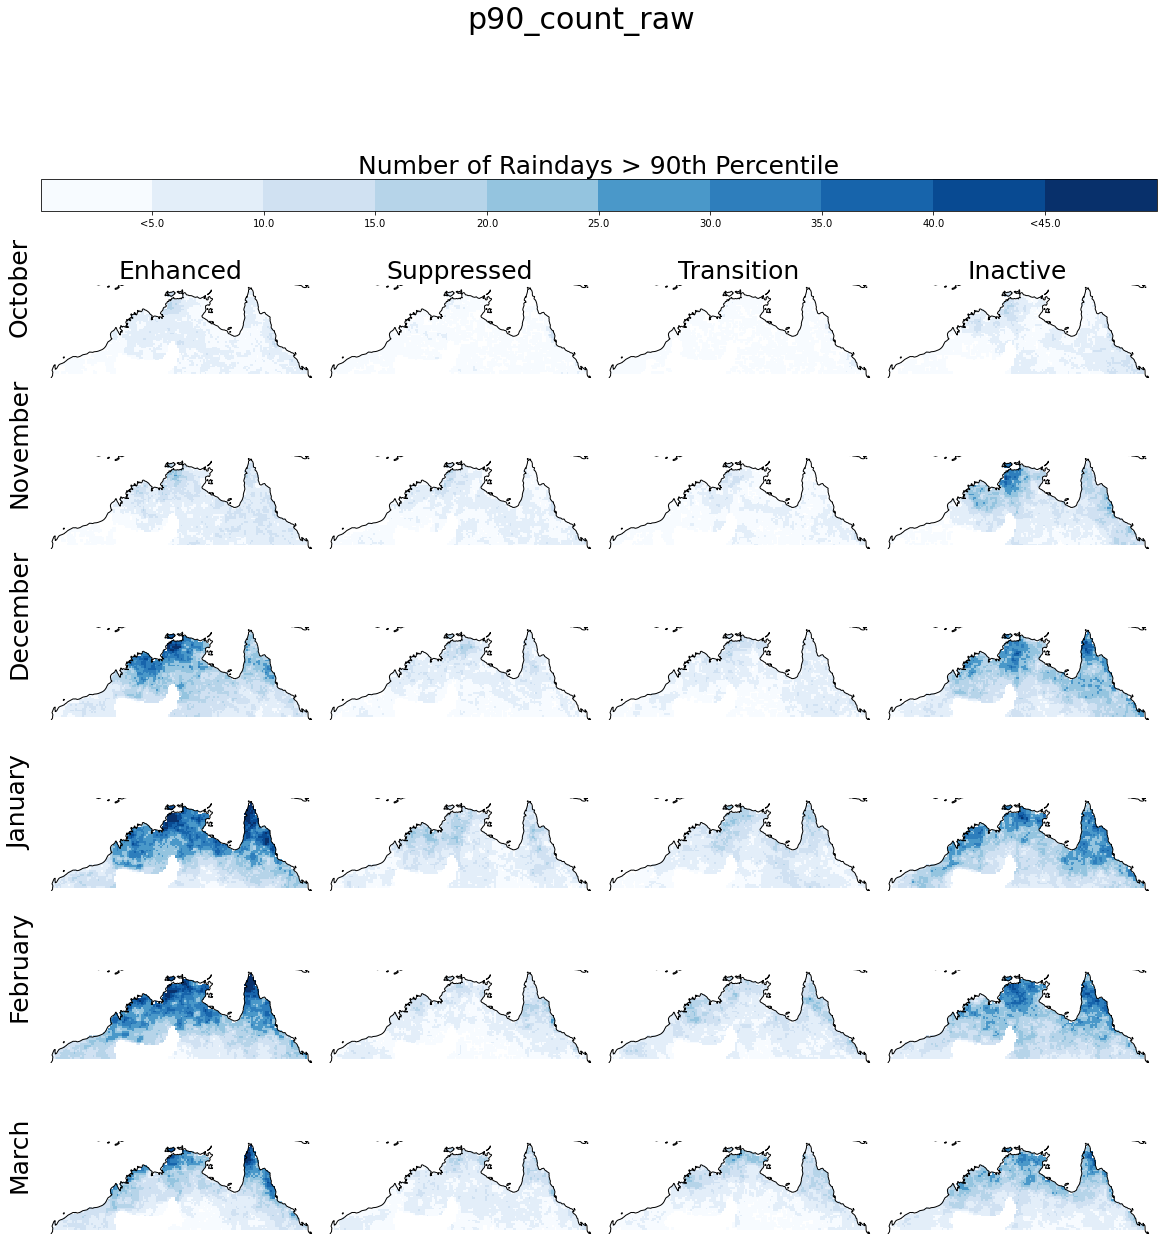

In [179]:
subplot_2 = reload(subplot_2)
subplot_2.anomalies_plots_sigle_phase_all_month_sample_count(awap_q_split_count.precip, figsize = (20,20),step = 5,
                                                             vmax = 50, 
                                                     cbar_title = f'Number of Raindays > {q}th Percentile', 
                                                             save_name = f'p{q}_count_raw'
                                                            ,savedir = savedir)

In [169]:
awap_q_split_percent = (awap_q_split_count.precip * 100/ awap_split_count.precip ).to_dataset(name = 'precip')

p90_count_percent has been saved


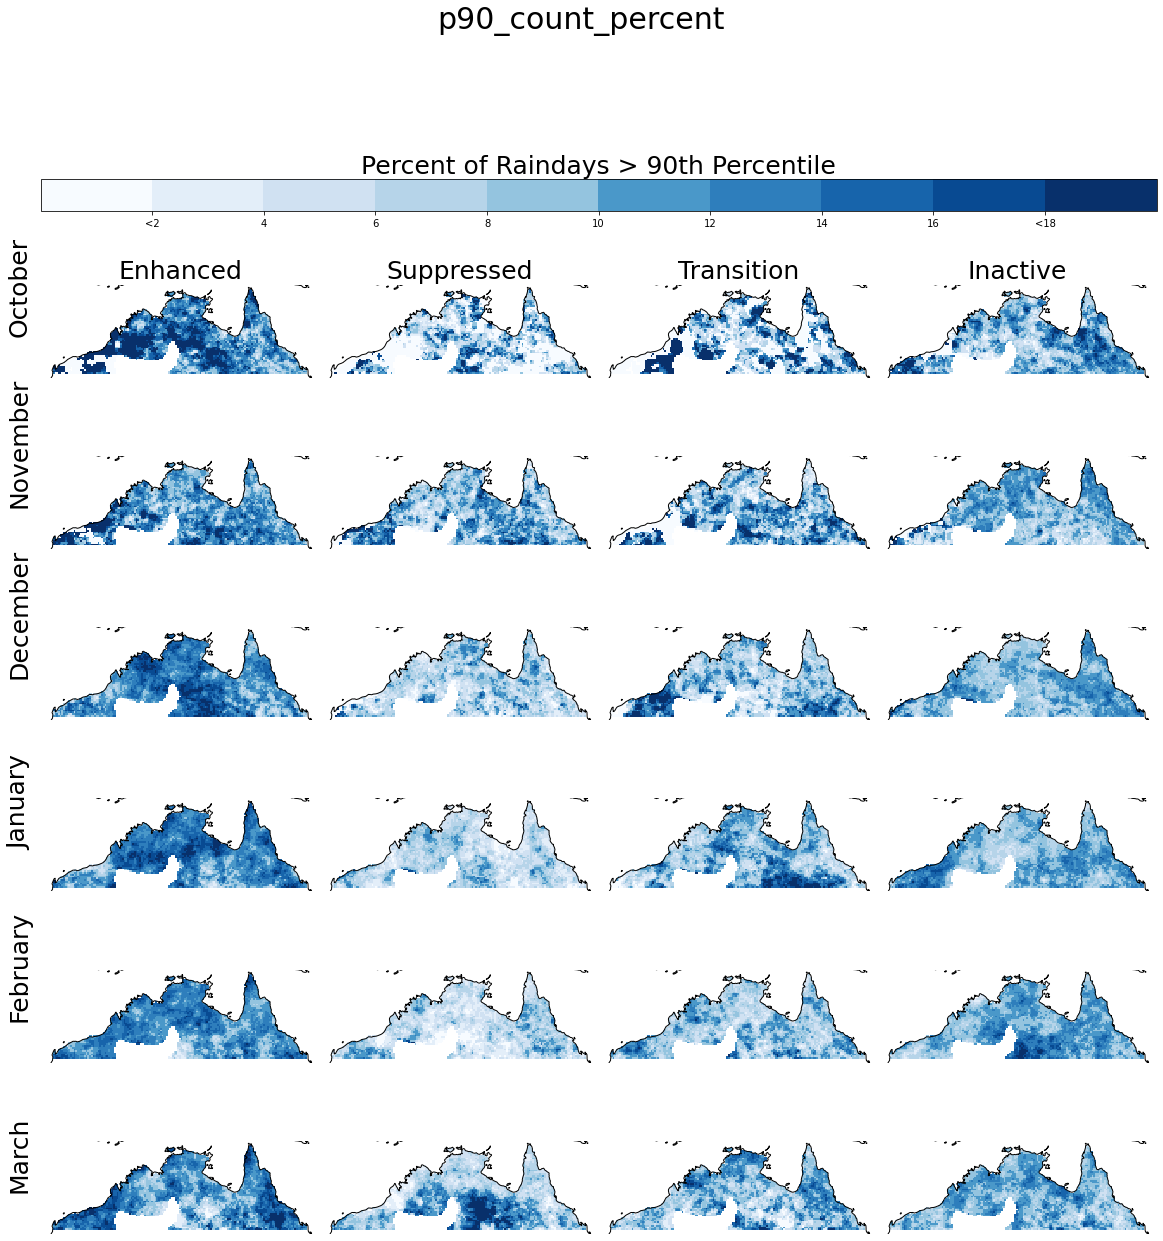

In [180]:
subplot_2 = reload(subplot_2)
subplot_2.anomalies_plots_sigle_phase_all_month_sample_count(awap_q_split_percent.precip, figsize = (20,20),
                                                             step = 2, vmax = 20,vmin = 0,
                                                     cbar_title = f'Percent of Raindays > {q}th Percentile', 
                                                             save_name = f'p{q}_count_percent'
                                                            ,savedir = savedir)

## Distributions

In [210]:
awap_q_split_mean.precip.median()

<xarray.DataArray 'precip' ()>
array(38.44884872)

In [245]:
med_mean = awap_q_split_mean.median().precip.values
med_mean

array(38.44884872)

In [247]:
med_count = awap_q_split_count.where(awap_q_split_count.precip != 0).median().precip.values
med_count

array(7.)

In [251]:
recherche_red = '#fbc4aa'
wondeful_white = '#f8f8f7'

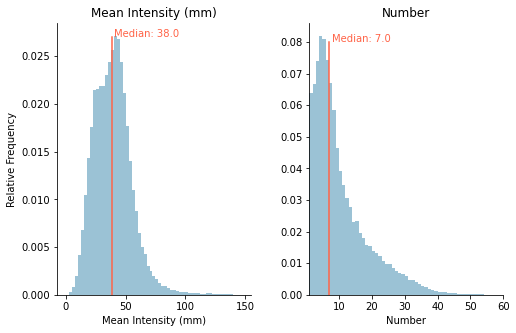

In [275]:
fig = plt.figure(figsize = (8,5))
gs = gridspec.GridSpec(1,2, wspace = 0.3)

ax = fig.add_subplot(gs[0])
awap_q_split_mean.precip.plot.hist(bins = np.arange(0,150,2.5), ax = ax, color = best_blue, density = True);
ax.plot([med_mean,med_mean], [0, 0.027], color = 'tomato')
ax.annotate(f'Median: {np.round(med_mean,0)}', xy = (med_mean + 2, 0.027), color = 'tomato')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Mean Intensity (mm)');
ax.set_ylabel('Relative Frequency');
ax.set_title('Mean Intensity (mm)');

ax = fig.add_subplot(gs[1])
awap_q_split_count.precip.plot.hist(bins = np.arange(1,60,1), ax = ax, color = best_blue, density = True);
ax.plot([med_count,med_count], [0, 0.08], color = 'tomato')
ax.annotate(f'Median: {med_count}', xy = (med_count + 1, 0.08), color = 'tomato')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Number');
ax.set_title('Number');
ax.set_xlim(1,60)
fig.savefig(savedir + 'pdf_analogy.png', dpi = 300, bbox_inches = 'tight', pad = 0)

## RMM Count Plots

In [49]:
rmm_count = subphase_calc.count_in_rmm_subphase_monthly(rmm)

In [50]:
rmm_count

<xarray.Dataset>
Dimensions:  (month: 6, phase: 4)
Coordinates:
  * phase    (phase) <U10 'enhanced' 'suppressed' 'transition' 'inactive'
  * month    (month) int64 10 11 12 1 2 3
Data variables:
    number   (month, phase) int64 328 248 155 549 272 ... 387 309 377 236 396

In [81]:
xticks = data.phase.values

xticks = [i.capitalize() for i in xticks]

In [87]:
best_blue = '#9bc2d5'

In [89]:
rmm_count

<xarray.Dataset>
Dimensions:  (month: 6, phase: 4)
Coordinates:
  * phase    (phase) <U10 'enhanced' 'suppressed' 'transition' 'inactive'
  * month    (month) int64 10 11 12 1 2 3
Data variables:
    number   (month, phase) int64 328 248 155 549 272 ... 387 309 377 236 396

In [94]:
import calendar

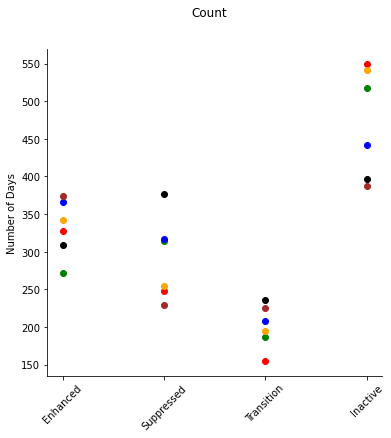

In [121]:
data_total = rmm_count

fig = plt.figure(figsize = (6,6))
gs = gridspec.GridSpec(1,1)

months = [10,11,12,1,2,3]
colors = ['red', 'green','orange','blue','brown', 'black','white']
markers = ['o', 'v', '^', '<', '>', '8']
fig.suptitle('Count')

for plot_num,month in enumerate(months):


    ax = fig.add_subplot(gs[0])

    data = data_total.sel(month = month).number
    x = np.arange(len(data))

    ax.scatter(x,data, color = colors[plot_num])
ax.set_xticks(x)
#     ax.set_title(calendar.month_name[month], fontsize = 15)

ax.set_xticklabels(xticks, rotation = 45);
ax.set_ylabel('Number of Days')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

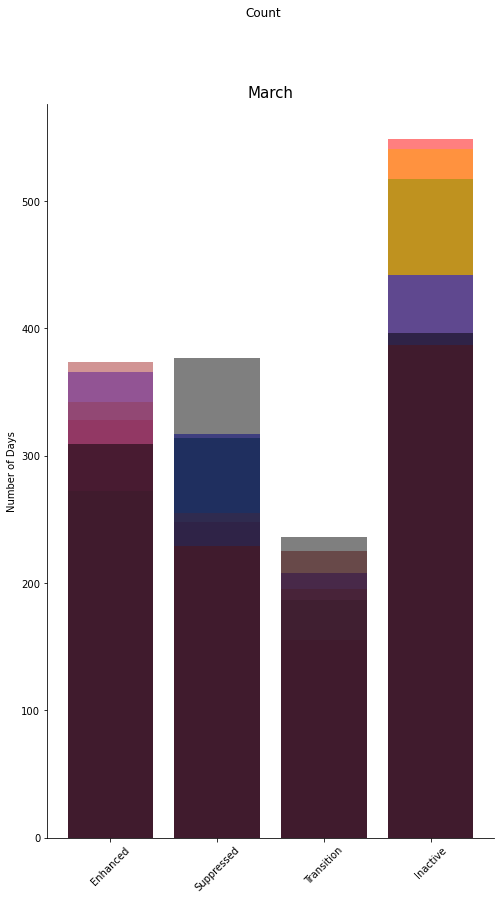

In [126]:
data_total = rmm_count

fig = plt.figure(figsize = (8,13.5))
gs = gridspec.GridSpec(1,1)
colors = ['red', 'green','orange','blue','brown', 'black','white']
months = [10,11,12,1,2,3]
fig.suptitle('Count')

for plot_num,month in enumerate(months):


    ax = fig.add_subplot(gs[0])

    data = data_total.sel(month = month).number
    x = np.arange(len(data))

    ax.bar(x,data,  color = colors[plot_num], alpha = 0.5)
    ax.set_xticks(x)
    ax.set_title(calendar.month_name[month], fontsize = 15)
    
    ax.set_xticklabels(xticks, rotation = 45);
    ax.set_ylabel('Number of Days')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

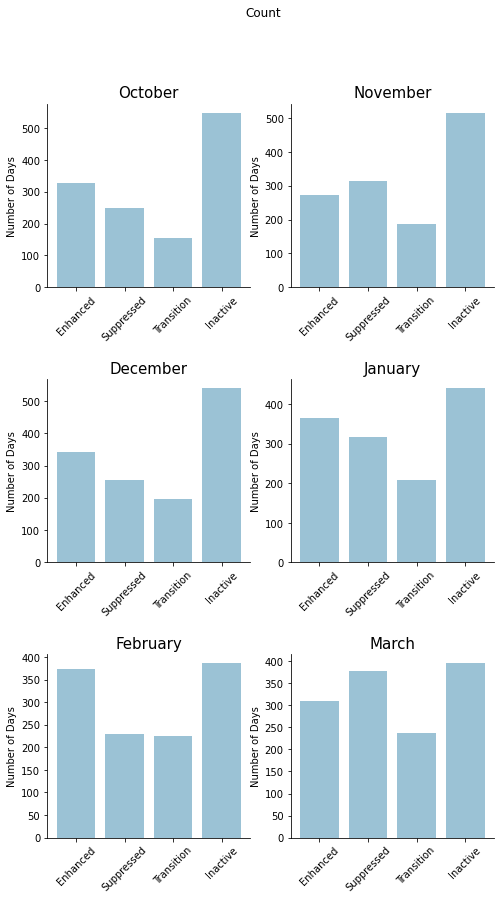

In [127]:
data_total = rmm_count

fig = plt.figure(figsize = (8,13.5))
gs = gridspec.GridSpec(3,2, hspace = 0.5)

months = [10,11,12,1,2,3]
fig.suptitle('Count')

for plot_num,month in enumerate(months):


    ax = fig.add_subplot(gs[plot_num])

    data = data_total.sel(month = month).number
    x = np.arange(len(data))

    ax.bar(x,data, color = best_blue)
    ax.set_xticks(x)
    ax.set_title(calendar.month_name[month], fontsize = 15)
    
    ax.set_xticklabels(xticks, rotation = 45);
    ax.set_ylabel('Number of Days')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    
fig.savefig(savedir + 'rmm_count.png', dpi = 400, bbox_inches = 'tight', pad = 0)

# Mean Rainfall
Calculation is the mean of the rainfall (all not just extreme) in each of the 1 to 8 and inactive phases of the MJO

In [13]:
awap_values, awap_anomalies =  phase_calc.calculate_1to8_anomalies_for_variables(awap)

In [14]:
savedir = 'images/rainfall/'

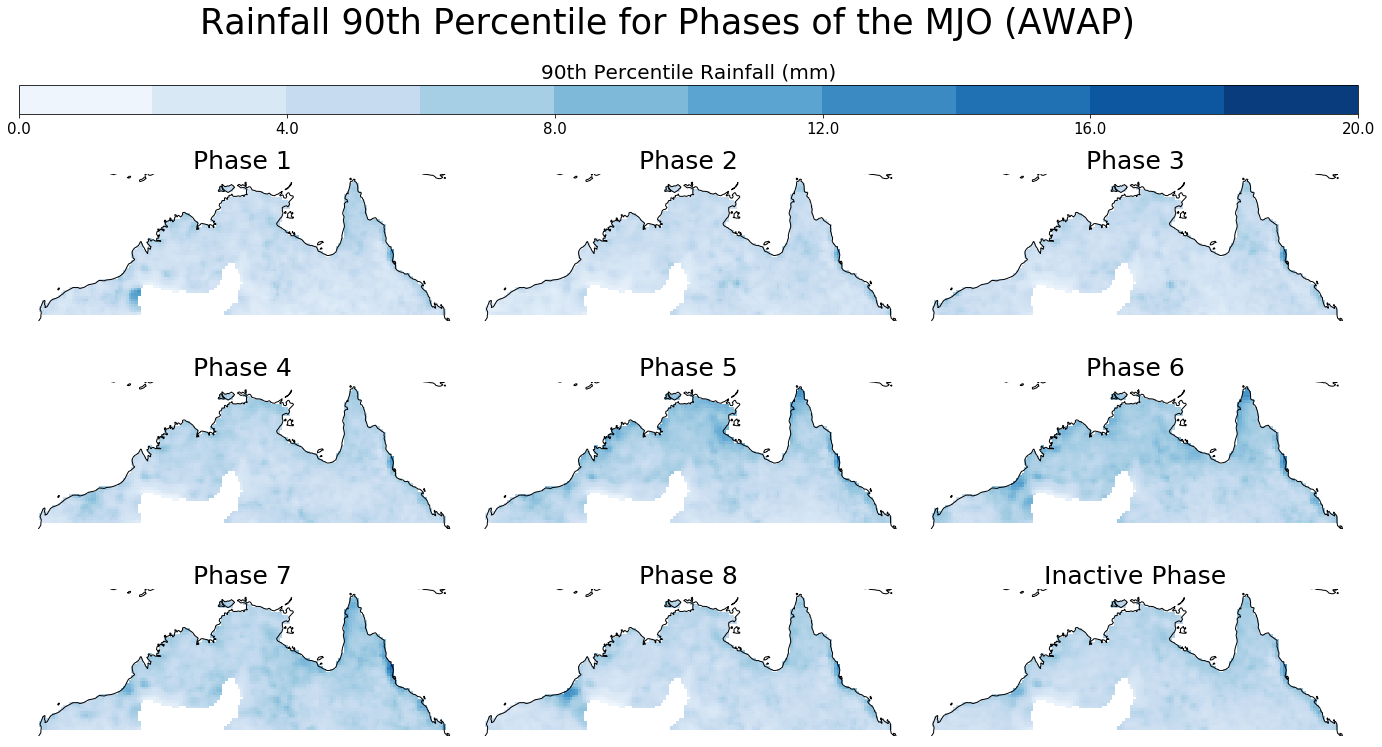

In [15]:
phase_plot = reload(phase_plot)
phase_plot.values_plots(awap_values.precip, cbar_num_steps = 11,
             title = 'Rainfall 90th Percentile for Phases of the MJO (AWAP)', 
                        cbar_title = '90th Percentile Rainfall (mm)',
                       savefig = 0, savedir = savedir)

10


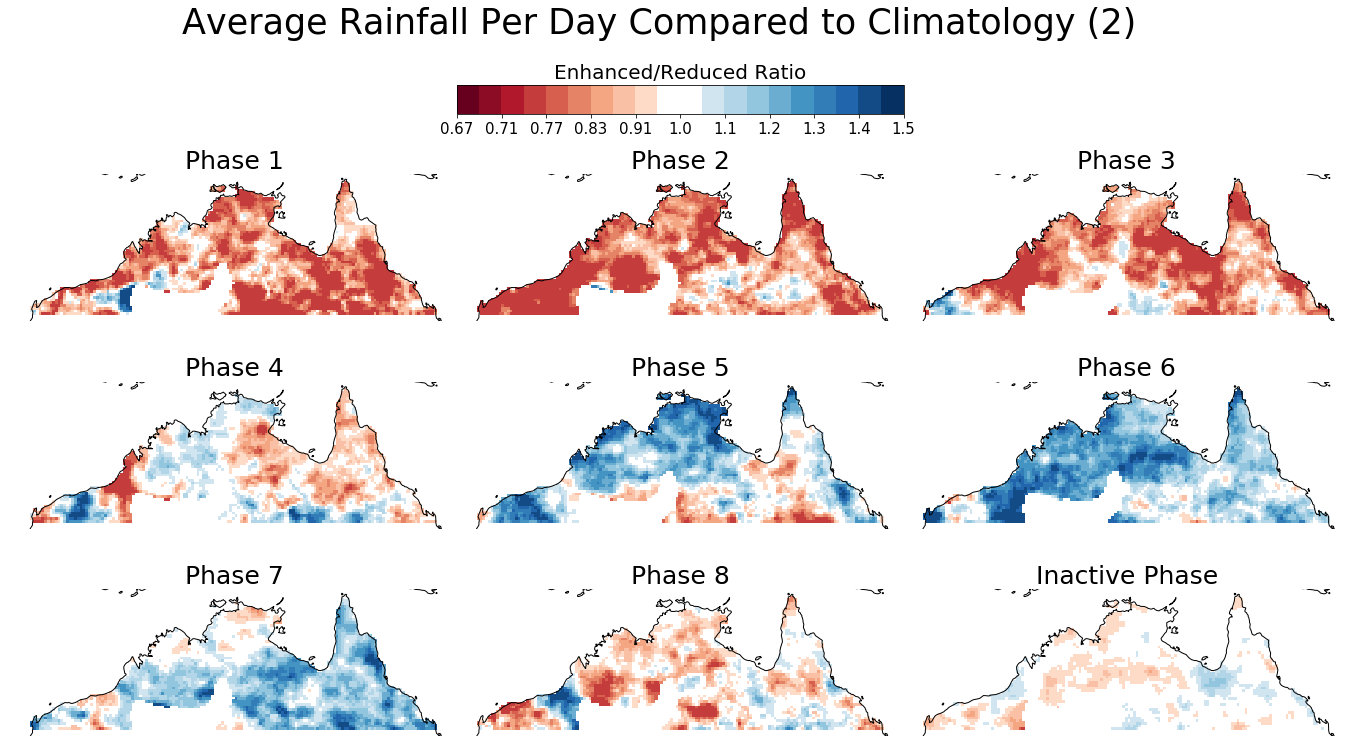

In [19]:
phase_plot = reload(phase_plot)
step = 0.05
end = 1.5
l1 = np.arange(1 + step, end + step, step)
phase_plot.anomalies_plots(awap_anomalies.precip, vmax = 1.5, l1 = l1,
                cbar_title = 'Enhanced/Reduced Ratio', title = 'Average Rainfall Per Day Compared to Climatology (2)',
                          savefig = 1, savedir = savedir, add_white = 1)

# Fraction of Days as Raindays

In [25]:
phase_calc = reload(phase_calc)

awap_split = phase_calc.split_into_1to8(awap, rmm)

awap_count_norm, awap_count_anomaly = phase_calc.count_and_anomly(awap_split, awap, rmm)

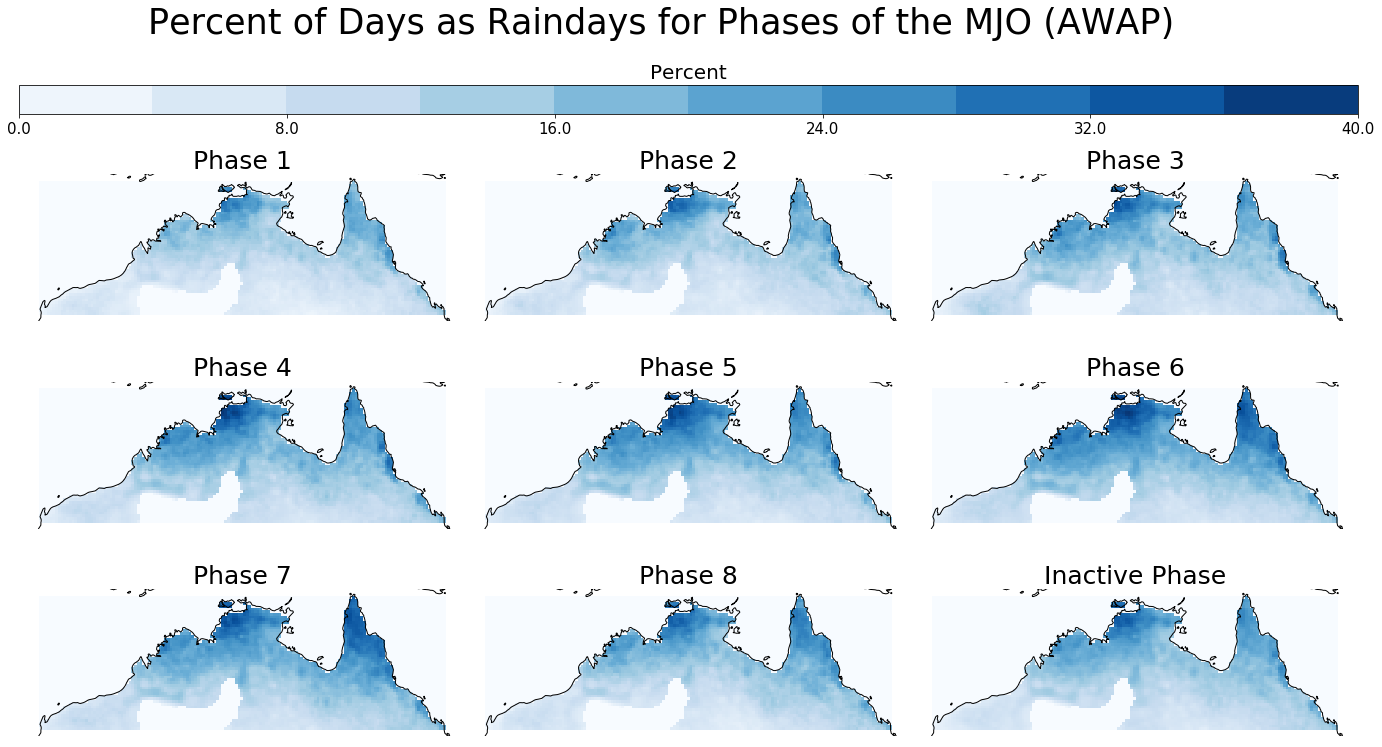

In [26]:
phase_plot = reload(phase_plot)
phase_plot.values_plots(awap_count_norm.precip, cbar_num_steps = 11,
             title = 'Percent of Days as Raindays for Phases of the MJO (AWAP) ', cbar_title = 'Percent',
                       savefig = 0,  savedir = savedir)

In [27]:
awap_count_norm

<xarray.Dataset>
Dimensions:  (lat: 49, lon: 149, phase: 9)
Coordinates:
  * phase    (phase) object '1' '2' '3' '4' '5' '6' '7' '8' 'inactive'
  * lon      (lon) float64 113.8 114.0 114.2 114.5 ... 150.0 150.2 150.5 150.8
  * lat      (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
Data variables:
    precip   (phase, lat, lon) float64 0.0 5.894 6.504 8.943 ... 0.0 0.0 0.0 0.0

10


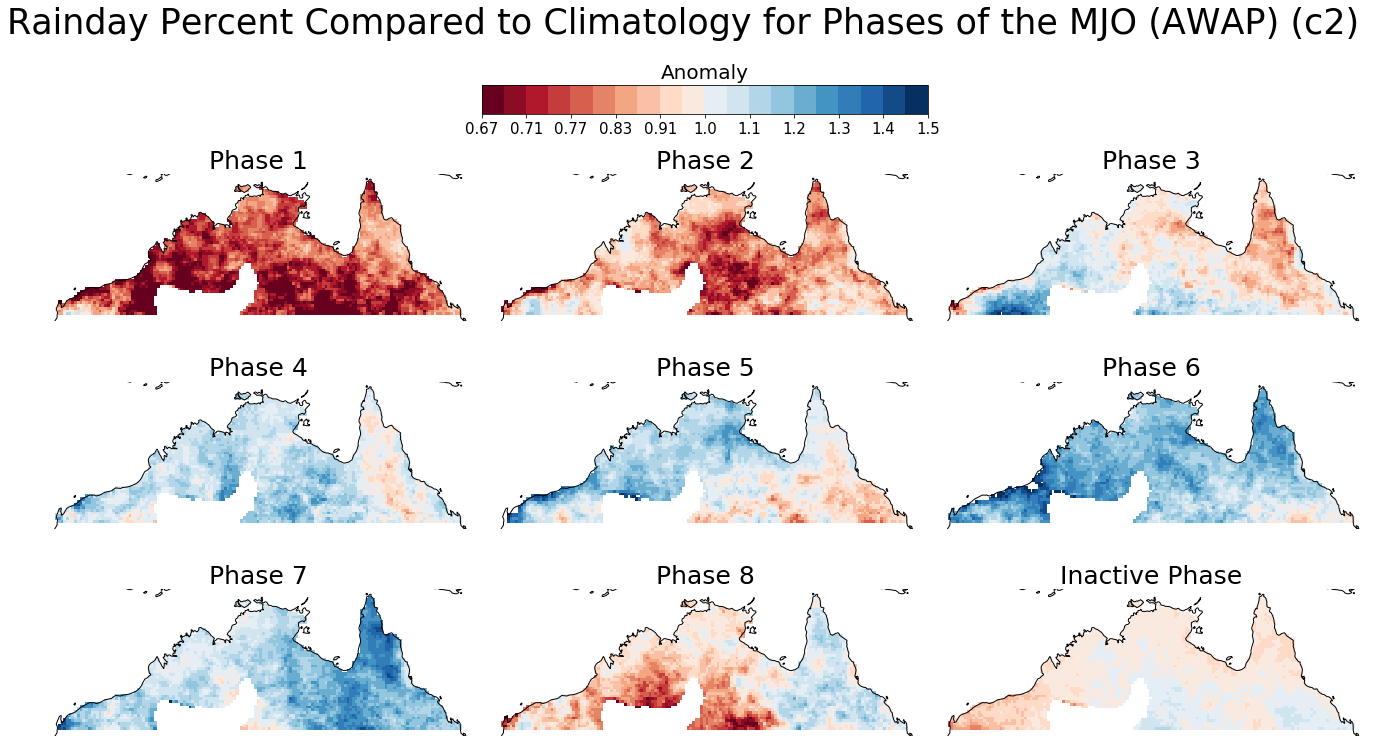

In [29]:
phase_plot = reload(phase_plot)
step = 0.05
end = 1.5
l1 = np.arange(1 + step, end + step, step)
phase_plot.anomalies_plots(awap_count_anomaly.precip, vmax = 2, l1 = l1,           
             title = 'Rainday Percent Compared to Climatology for Phases of the MJO (AWAP) (c2)', 
                           cbar_title = 'Anomaly',
                       savefig = 1, savedir = savedir)

# Fraction of Days as Raindays (monthly)

In [8]:
phase_calc = reload(phase_calc)

awap_split = phase_calc.split_into_1to8(awap, rmm)

awap_count_norm, awap_count_anomaly = phase_calc.count_and_anomly_month(awap_split, awap, rmm)

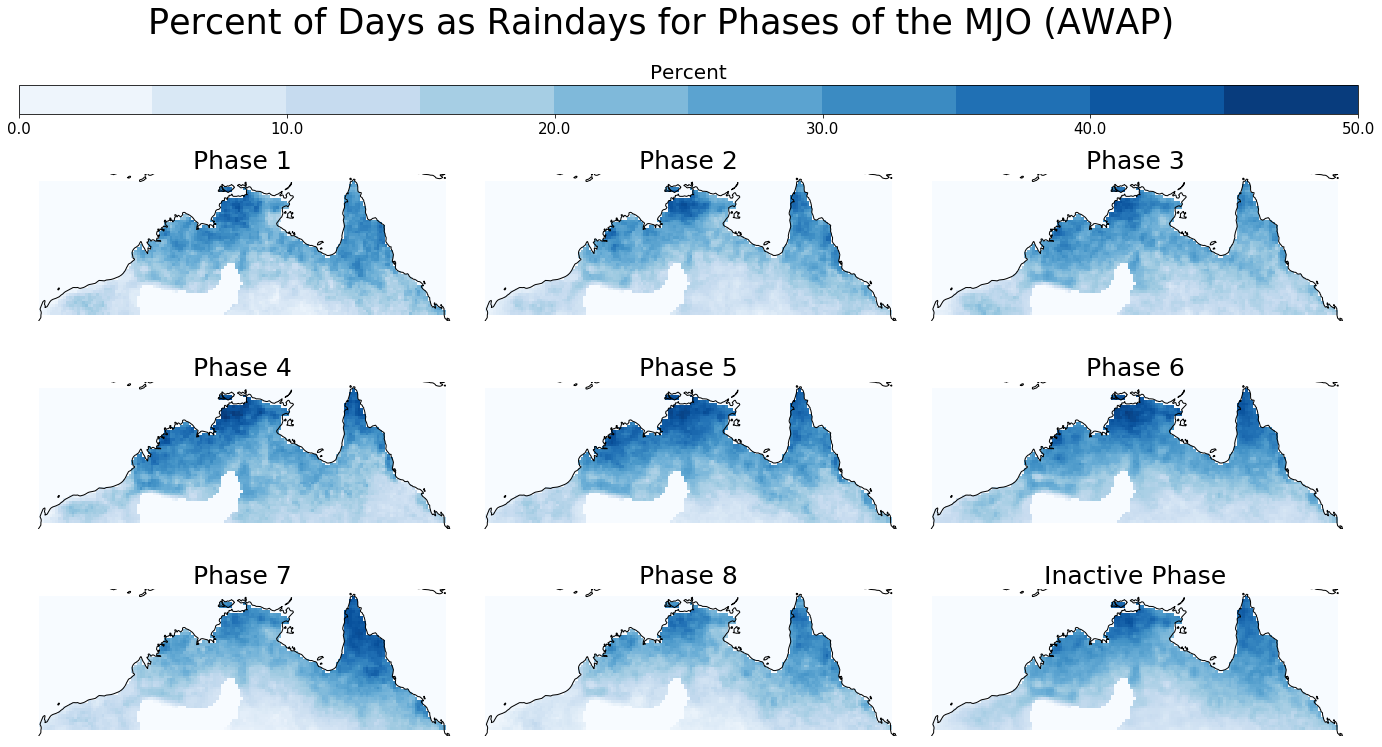

In [9]:
phase_plot = reload(phase_plot)
month = 1
phase_plot.values_plots(awap_count_norm.sel(month = month).precip, cbar_num_steps = 11,
             title = 'Percent of Days as Raindays for Phases of the MJO (AWAP) ', cbar_title = 'Percent',
                       savefig = 0,  savedir = savedir)

In [10]:
awap_count_norm

<xarray.Dataset>
Dimensions:  (lat: 49, lon: 149, month: 6, phase: 9)
Coordinates:
  * lon      (lon) float64 113.8 114.0 114.2 114.5 ... 150.0 150.2 150.5 150.8
  * lat      (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
  * phase    (phase) object '1' '2' '3' '4' '5' '6' '7' '8' 'inactive'
  * month    (month) int64 10 11 12 1 2 3
Data variables:
    precip   (month, phase, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [11]:
import calendar
calendar.month_name[1]

'January'

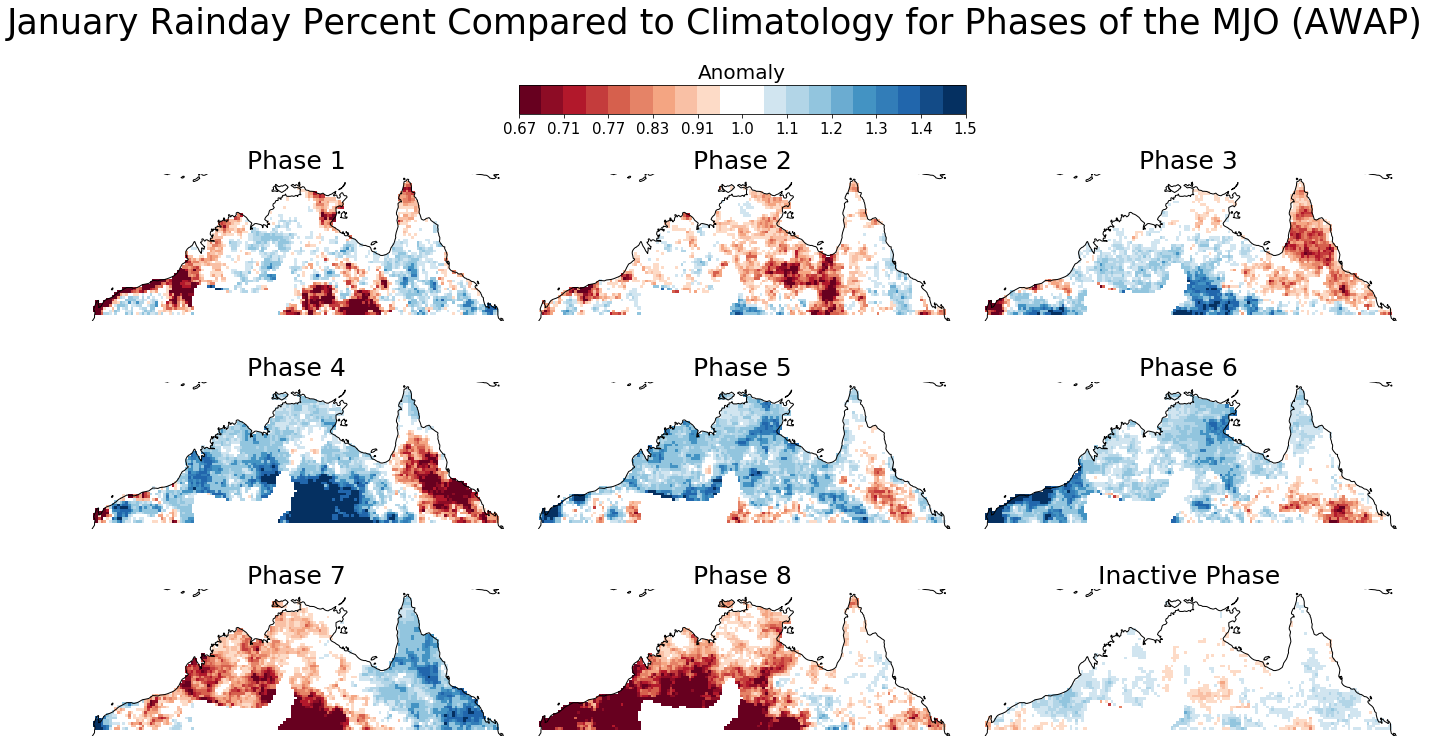

In [12]:
phase_plot = reload(phase_plot)
step = 0.05
end = 1.5
l1 = np.arange(1 + step, end + step, step)
phase_plot.anomalies_plots(awap_count_anomaly.sel(month = month).precip, vmax = 1.5, l1 = l1,           
             title = calendar.month_name[month] + ' Rainday Percent Compared to Climatology for Phases of the MJO (AWAP) ', 
                           cbar_title = 'Anomaly',
                       savefig = 1, savedir = savedir)

In [20]:
savedir

'images/rainfall/'

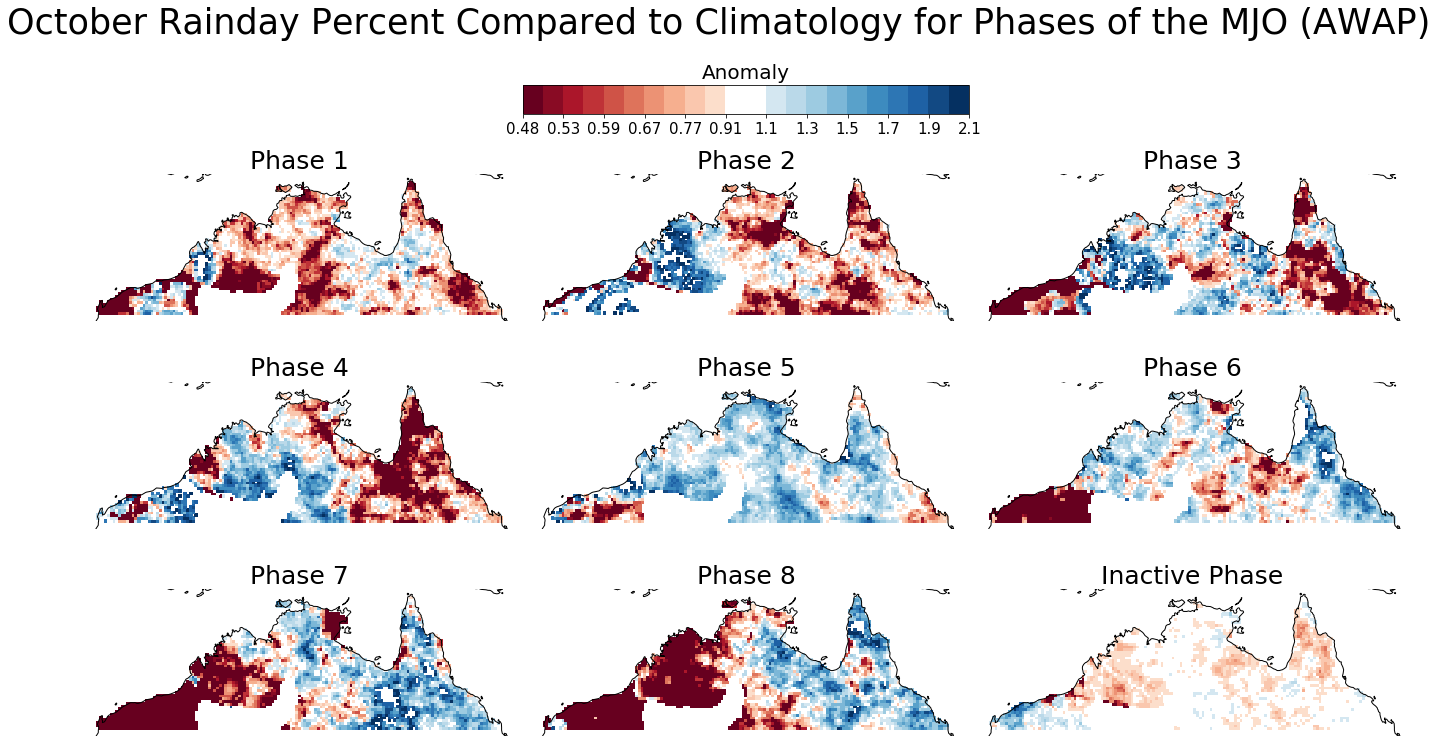

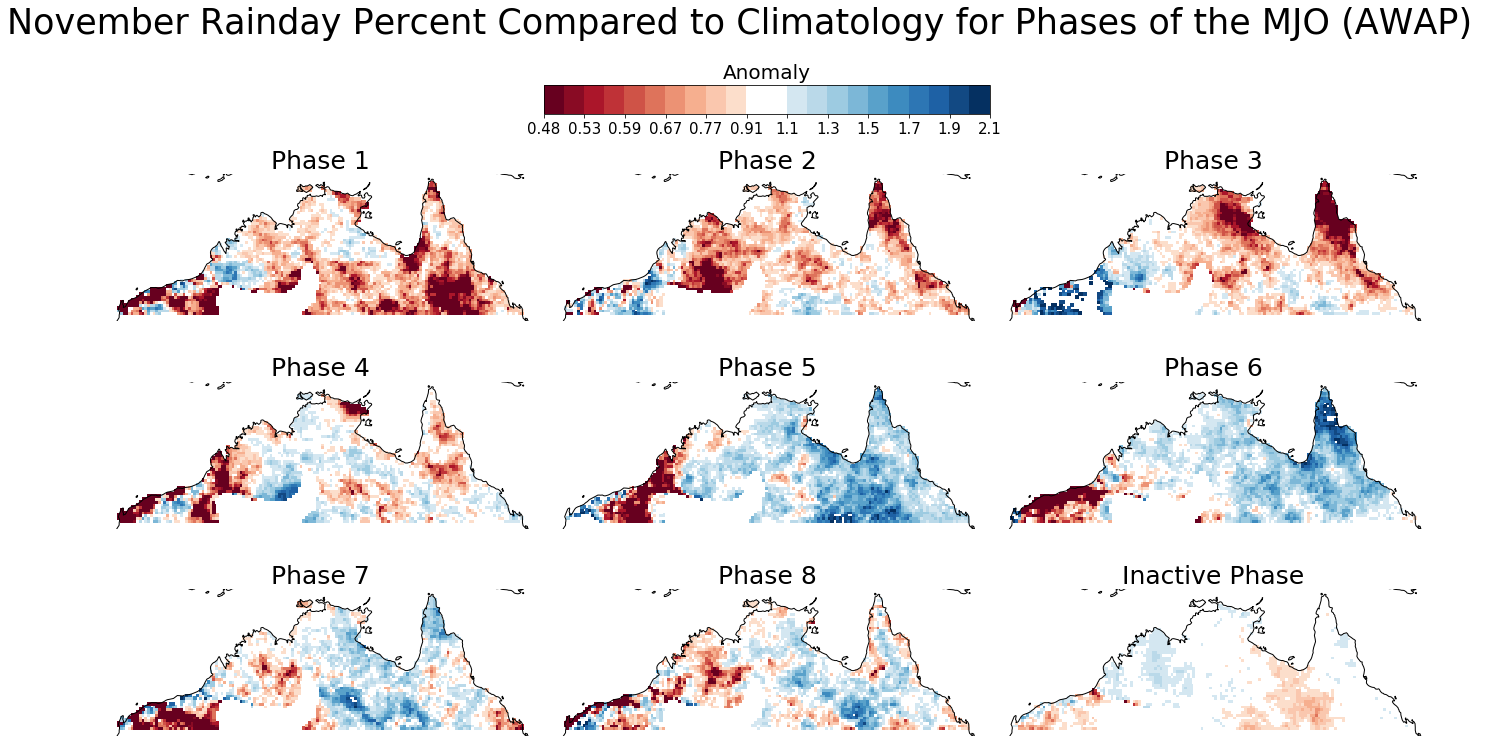

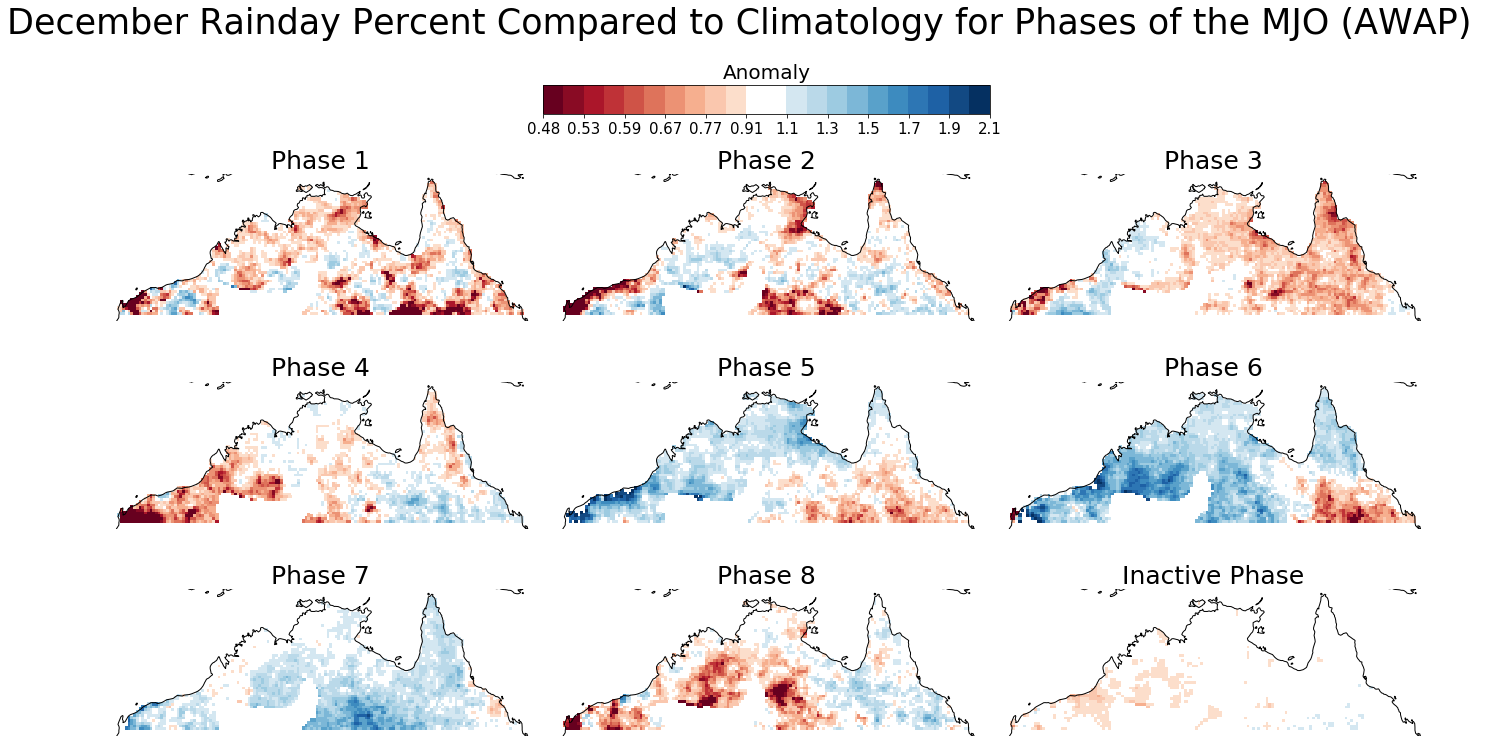

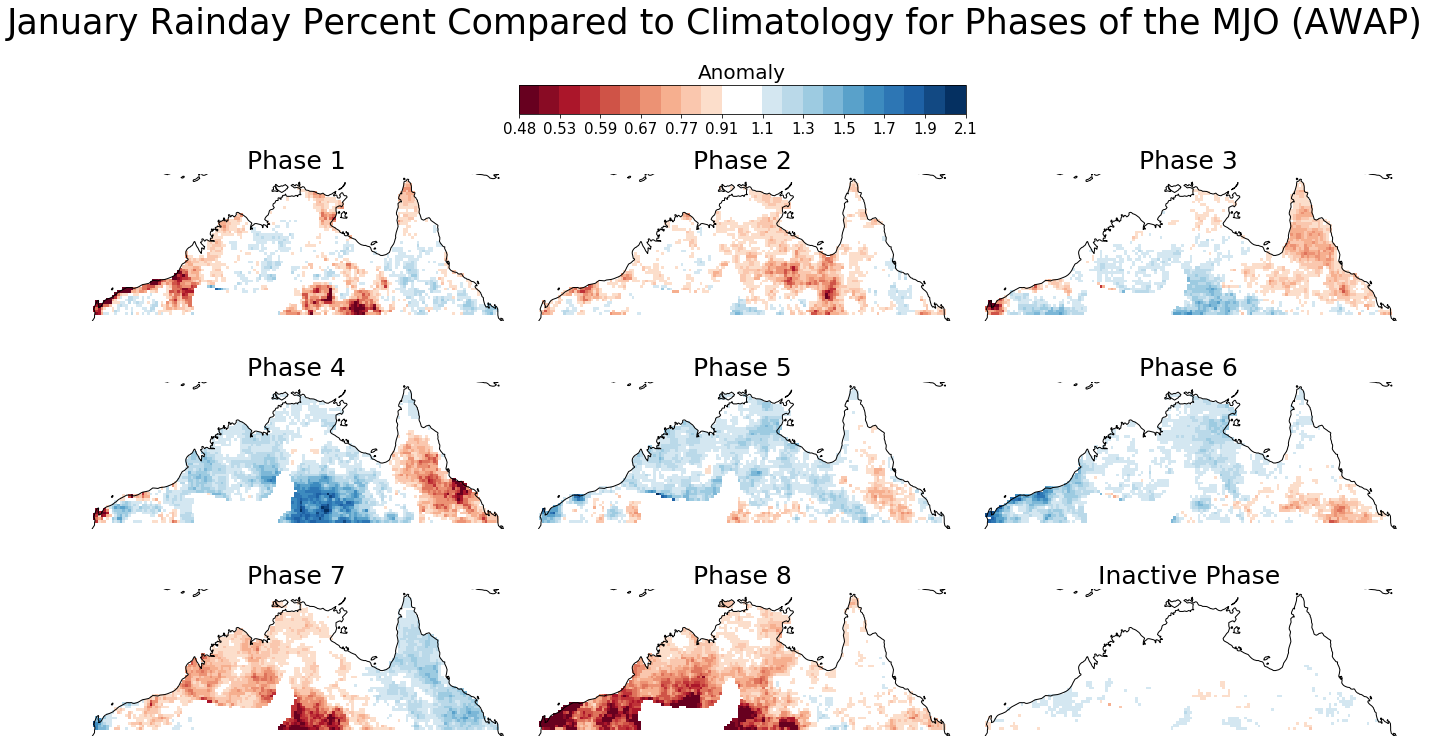

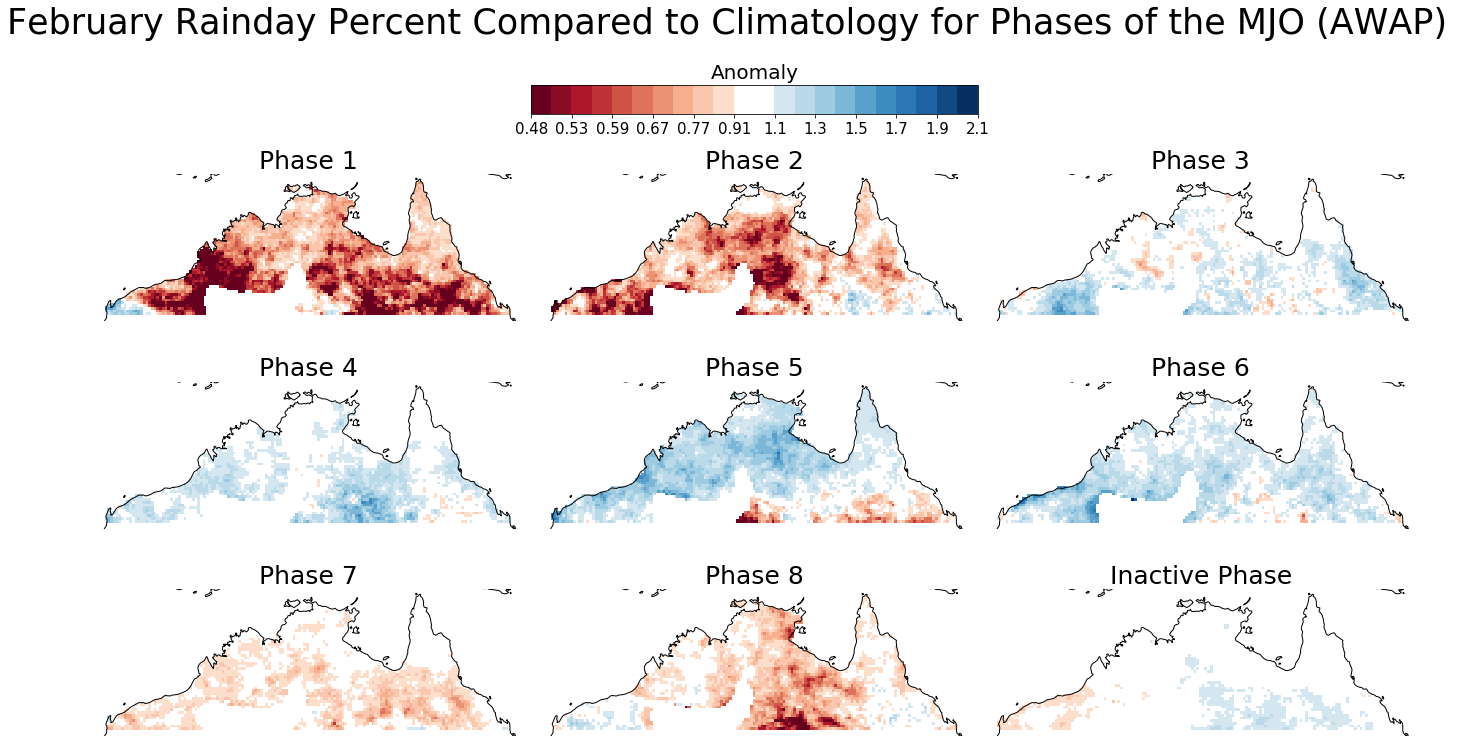

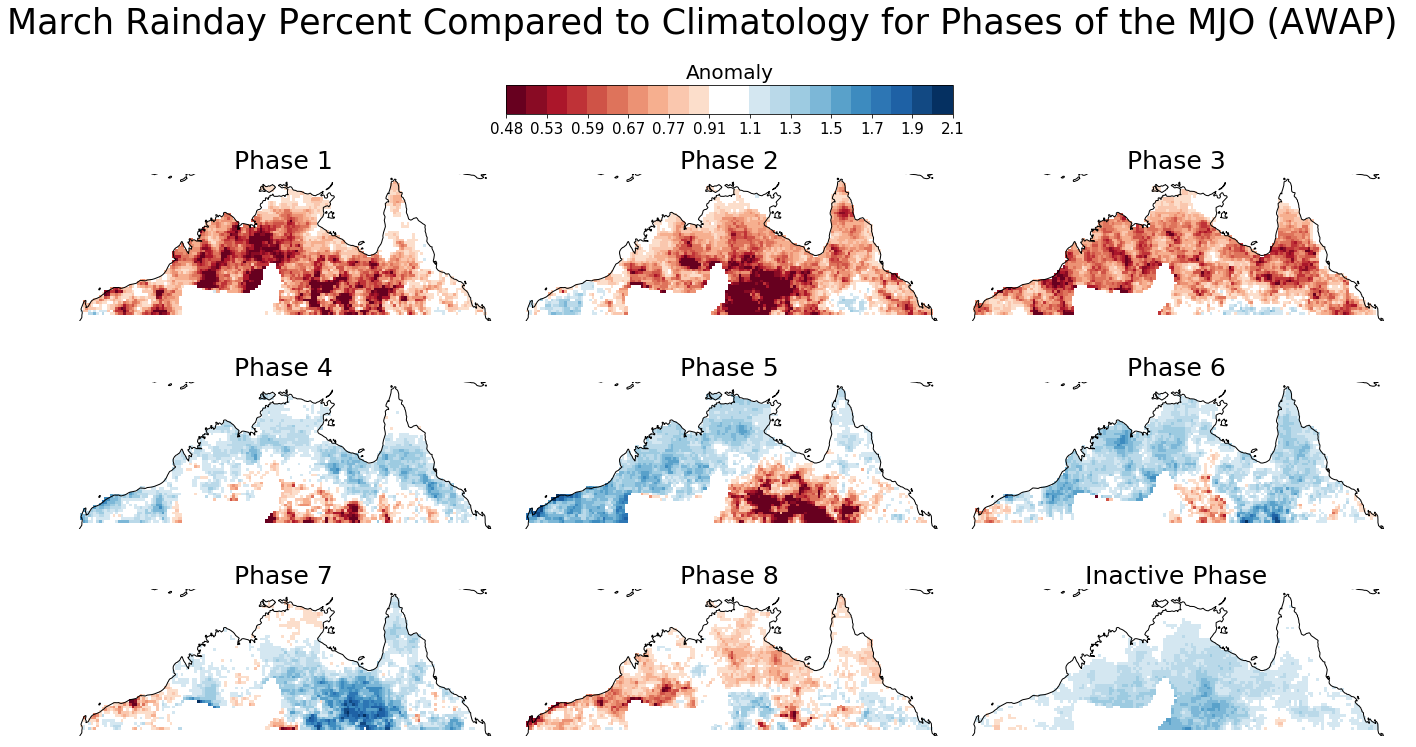

In [21]:
phase_plot = reload(phase_plot)


# step = 0.05
# end = 1.5
# l1 = np.arange(1 + step, end + step, step)
l1 = []

for month in [10,11,12,1,2,3]:

    phase_plot.anomalies_plots(awap_count_anomaly.sel(month = month).precip, vmax = 2.1, l1 = l1,           
                 title = calendar.month_name[month] + ' Rainday Percent Compared to Climatology for Phases of the MJO (AWAP) ', 
                               cbar_title = 'Anomaly',
                           savefig = 1, savedir = savedir, dontplot = 0)

# Average Rain Sum

In [9]:
phase_calc = reload(phase_calc)

awap_split = phase_calc.split_into_1to8(awap, rmm)

awap_sum_norm, awap_sum_anomaly = phase_calc.sum_and_anomly(awap_split, awap, rmm)

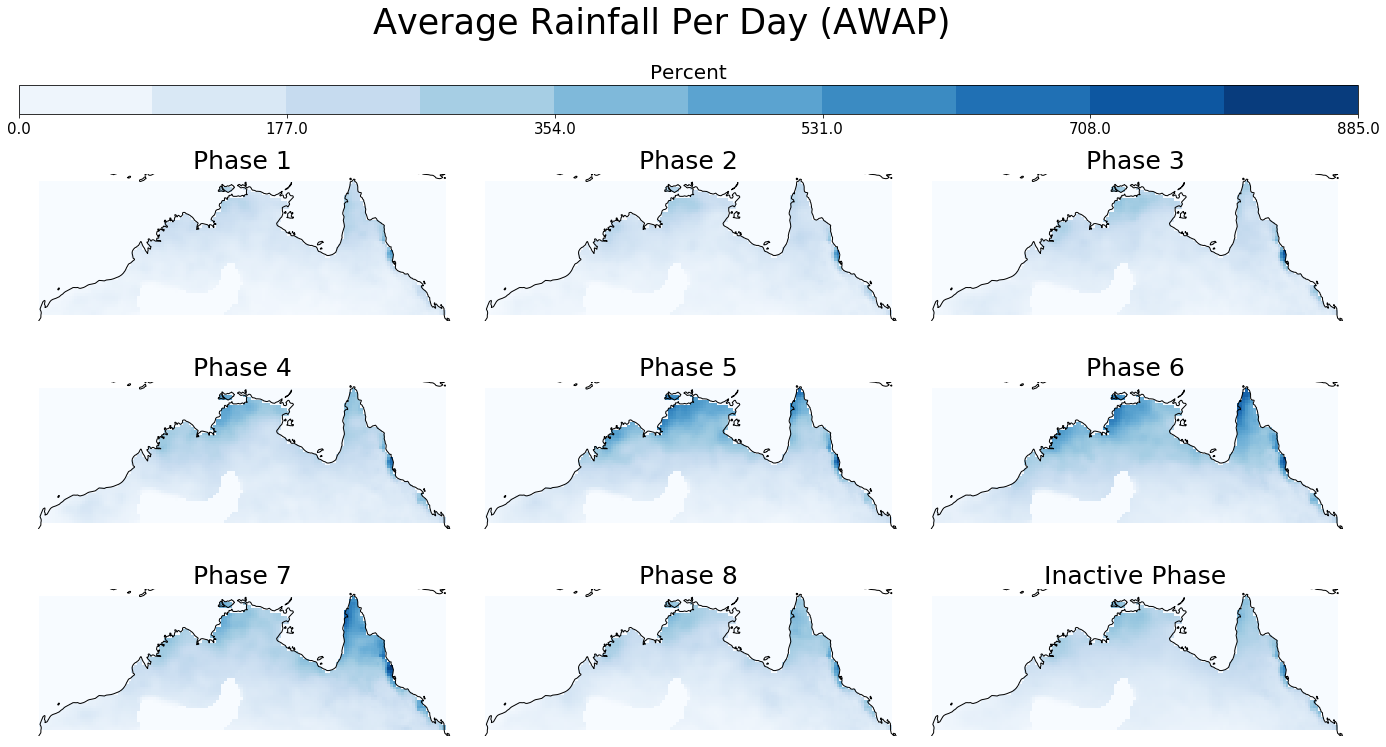

In [10]:
phase_plot = reload(phase_plot)
phase_plot.values_plots(awap_sum_norm.precip, cbar_num_steps = 11,
             title = 'Average Rainfall Per Day (AWAP) ', cbar_title = 'Percent',
                       savefig = 0,  savedir = savedir)

In [11]:
awap_sum_norm

<xarray.Dataset>
Dimensions:  (lat: 49, lon: 149, phase: 9)
Coordinates:
  * phase    (phase) object '1' '2' '3' '4' '5' '6' '7' '8' 'inactive'
  * lon      (lon) float64 113.8 114.0 114.2 114.5 ... 150.0 150.2 150.5 150.8
  * lat      (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
Data variables:
    precip   (phase, lat, lon) float64 0.0 58.49 63.77 69.8 ... 0.0 0.0 0.0 0.0

0


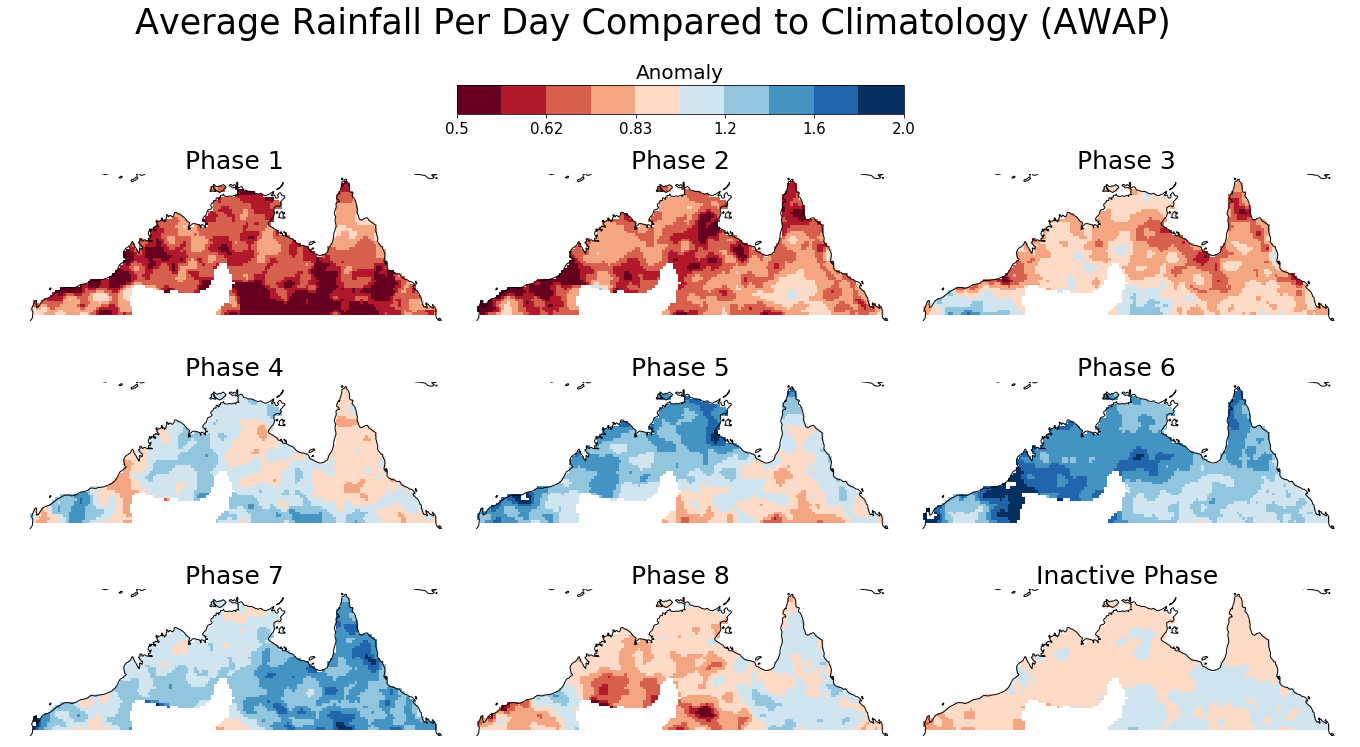

In [24]:
phase_plot = reload(phase_plot)
# step = 0.05
# end = 1.5
# l1 = np.arange(1 + step, end + step, step)
l1 = []

phase_plot.anomalies_plots(awap_sum_anomaly.precip, vmax = 2, l1 = l1,           
             title = 'Average Rainfall Per Day Compared to Climatology (AWAP) ', 
                           cbar_title = 'Anomaly',
                       savefig = 1, savedir = savedir)